In [1]:
import scipy.io as sio
import numpy as np
import os
# import pandas as pd
# import matplotlib.pyplot as plt

mat = sio.loadmat('ecog-hand-pose/ecog-hand-pose/ECoG_Handpose.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'y'])


In [2]:
print(mat['y'].shape)
print(mat['y'].dtype)
# print(mat['y'])
data = mat['y']
print(data.shape)

(67, 507025)
float64
(67, 507025)


In [3]:
from scipy.signal import butter, lfilter
import scipy
import numpy as np

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def one_hot(y_):
    y_ = y_.reshape(len(y_))
    y_ = [int(xx) for xx in y_]
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

def extract(input, n_classes, n_fea, time_window, moving):
    # xx = input[:, :n_fea]
    # yy = input[:, n_fea:n_fea + 1]
    xx = np.concatenate((input[:,1:61],input[:,62:]), axis=1)
    yy = input[:,61]
    new_x = []
    new_y = []
    number = int((xx.shape[0] / moving) - 1)
    for i in range(number):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        if ave_y in range(n_classes):
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(ave_y)
        else:
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(0)

    new_x = np.array(new_x)
    new_x = new_x.reshape([-1, n_fea * time_window])
    new_y = np.array(new_y)
    new_y.shape = [new_y.shape[0], 1]
    data = np.hstack((new_x, new_y))
    data = np.vstack((data, data[-1]))  # add the last sample again, to make the sample number round
    return data

In [4]:
n_class = 4
no_feature = 65  # the number of the features
segment_length = 16  # selected time window; 16=160*0.1

# segment data, check more details about the 'extract' function in BCI_functions.ipynb
data_seg = extract(data.T, n_classes=n_class, n_fea=no_feature, time_window=segment_length, moving=(segment_length/2))  # 50% overlapping

print('After segmentation, the shape of the data:', data_seg.shape)


After segmentation, the shape of the data: (63378, 1041)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report

# import myimporter
# from BCI_functions import *  # BCI_functions.ipynb contains some functions we might use multiple times in this tutorial
import warnings
warnings.filterwarnings('ignore')

# split training and test data
no_longfeature = no_feature*segment_length
data_seg_feature = data_seg[:, :no_longfeature]
data_seg_label = data_seg[:, no_longfeature:no_longfeature+1]
train_feature, test_feature, train_label, test_label = train_test_split(data_seg_feature, data_seg_label,test_size=0.2, shuffle=True)

# normalization
# before normalize reshape data back to raw data shape
train_feature_2d = train_feature.reshape([-1, no_feature])
test_feature_2d = test_feature.reshape([-1, no_feature])

scaler1 = StandardScaler().fit(train_feature_2d)
train_fea_norm1 = scaler1.transform(train_feature_2d) # normalize the training data
test_fea_norm1 = scaler1.transform(test_feature_2d) # normalize the test data
print('After normalization, the shape of training feature:', train_fea_norm1.shape,
      '\nAfter normalization, the shape of test feature:', test_fea_norm1.shape)

# after normalization, reshape data to 3d in order to feed in to LSTM
train_fea_norm1 = train_fea_norm1.reshape([-1, segment_length, no_feature])
test_fea_norm1 = test_fea_norm1.reshape([-1, segment_length, no_feature])
print('After reshape, the shape of training feature:', train_fea_norm1.shape,
      '\nAfter reshape, the shape of test feature:', test_fea_norm1.shape)

BATCH_size = test_fea_norm1.shape[0] # use test_data as batch size


After normalization, the shape of training feature: (811232, 65) 
After normalization, the shape of test feature: (202816, 65)
After reshape, the shape of training feature: (50702, 16, 65) 
After reshape, the shape of test feature: (12676, 16, 65)


In [ ]:
LR = 0.005  # learning rate
n_hidden = 128  # number of neurons in hidden layer
l2 = 0.001  # the coefficient of l2-norm regularization

# check if a GPU is available
with_gpu = torch.cuda.is_available()
if with_gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('We are using %s now.' %device)

# feed data into dataloader
train_fea_norm1 = torch.tensor(train_fea_norm1).to(device)
train_label = torch.tensor(train_label.flatten()).to(device)
train_data = Data.TensorDataset(train_fea_norm1, train_label)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=False)

test_fea_norm1 = torch.tensor(test_fea_norm1).to(device)
test_label = torch.tensor(test_label.flatten()).to(device)


# classifier
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm_layer = nn.LSTM(
            input_size=no_feature,
            hidden_size=n_hidden,         # LSTM hidden unit
            num_layers=2,           # number of LSTM layer
            bias=True,
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, segment_length, no_feature)
        )

        self.out = nn.Linear(n_hidden, n_class)

    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm_layer(x.float(), None)
        r_out = F.dropout(r_out, 0.3)

        test_output = self.out(r_out[:, -1, :]) # choose r_out at the last time step
        return test_output

lstm = LSTM()
lstm.to(device)
print(lstm)

optimizer = torch.optim.Adam(lstm.parameters(), lr=LR, weight_decay=l2)   # optimize all parameters
loss_func = nn.CrossEntropyLoss()


We are using cuda now.
LSTM(
  (lstm_layer): LSTM(65, 128, num_layers=2, batch_first=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
)


In [18]:


best_acc = []
best_auc = []

EPOCH = 1000

train_loss_l = []
test_loss_l = []
train_acc_l = []
test_acc_l = []

# training and testing
start_time = time.perf_counter()
for epoch in range(EPOCH):
    for step, (train_x, train_y) in enumerate(train_loader):

        output = lstm(train_x)  # LSTM output of training data
        loss = loss_func(output, train_y.long())  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if epoch % 10 == 0 and step==2:
            test_output = lstm(test_fea_norm1)  # LSTM output of test data
            test_loss = loss_func(test_output, test_label.long())

            test_y_score = one_hot(test_label.data.cpu().numpy())  # .cpu() can be removed if your device is cpu.
            pred_score = F.softmax(test_output, dim=1).data.cpu().numpy()  # normalize the output
            auc_score = roc_auc_score(test_y_score, pred_score)

            pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
            pred_train = torch.max(output, 1)[1].data.cpu().numpy()

            test_acc = accuracy_score(test_label.data.cpu().numpy(), pred_y)
            train_acc = accuracy_score(train_y.data.cpu().numpy(), pred_train)


            # print('Epoch: ', epoch, '|train loss: %.4f' % loss.item(),
            #       ' train ACC: %.4f' % train_acc, '| test loss: %.4f' % test_loss.item(),
            #       'test ACC: %.4f' % test_acc, '| AUC: %.4f' % auc_score)
            print('Epoch: ', epoch, '|train loss: %.4f' % loss.item(),
                  ' train ACC: %.4f' % train_acc, '| test loss: %.4f' % test_loss.item(),
                  'test ACC: %.4f' % test_acc)
            best_acc.append(test_acc)
            best_auc.append(auc_score)

            train_loss_l.append(loss.item())
            test_loss_l.append(test_loss.item())
            train_acc_l.append(train_acc)
            test_acc_l.append(test_acc)
            if epoch % 50 == 0:
                torch.save(lstm.state_dict(), 'lstm_model_epoch_%i.pth' % epoch)  # save the model every 10 epochs

current_time = time.perf_counter()
running_time = current_time - start_time
print(classification_report(test_label.data.cpu().numpy(), pred_y))
# print('BEST TEST ACC: {}, AUC: {}'.format(max(best_acc), max(best_auc)))
print('BEST TEST ACC: {}'.format(max(best_acc)))
print("Total Running Time: {} seconds".format(round(running_time, 2)))


Epoch:  0 |train loss: 0.0733  train ACC: 0.9721 | test loss: 0.0796 test ACC: 0.9710
Epoch:  10 |train loss: 0.0735  train ACC: 0.9714 | test loss: 0.0811 test ACC: 0.9694
Epoch:  20 |train loss: 0.0668  train ACC: 0.9761 | test loss: 0.0689 test ACC: 0.9736
Epoch:  30 |train loss: 0.0771  train ACC: 0.9710 | test loss: 0.0826 test ACC: 0.9685
Epoch:  40 |train loss: 0.0677  train ACC: 0.9752 | test loss: 0.0892 test ACC: 0.9670
Epoch:  50 |train loss: 0.0674  train ACC: 0.9745 | test loss: 0.0666 test ACC: 0.9759
Epoch:  60 |train loss: 0.0596  train ACC: 0.9776 | test loss: 0.0843 test ACC: 0.9717
Epoch:  70 |train loss: 0.0729  train ACC: 0.9729 | test loss: 0.0904 test ACC: 0.9686
Epoch:  80 |train loss: 0.0570  train ACC: 0.9815 | test loss: 0.0770 test ACC: 0.9715
Epoch:  90 |train loss: 0.0610  train ACC: 0.9785 | test loss: 0.0711 test ACC: 0.9747
Epoch:  100 |train loss: 0.0620  train ACC: 0.9778 | test loss: 0.0684 test ACC: 0.9754
Epoch:  110 |train loss: 0.0668  train ACC:

train_loss_l: 100
test_loss_l: 100
epochs: 20


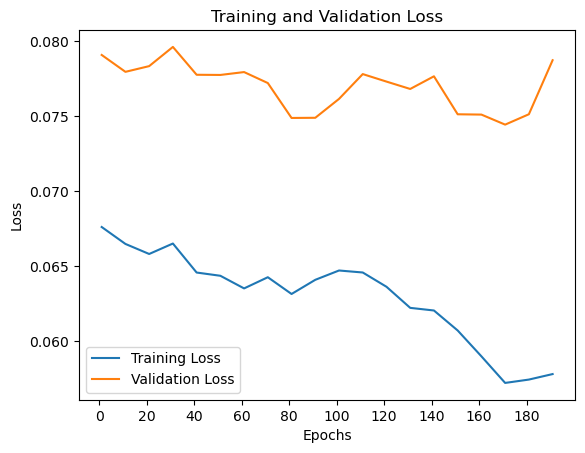

In [ ]:
from matplotlib.pylab import plt
from numpy import arange

def moving_average(data, window_size):
    if len(data) < window_size:
        raise ValueError("Window size cannot be larger than the data size.")
    
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

print('train_loss_l:', len(train_loss_l))
print('test_loss_l:', len(test_loss_l))
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 200,10)
print('epochs:', len(epochs))

train_sl = moving_average(train_loss_l, 10)
test_sl = moving_average(test_loss_l, 10)

# Plot and label the training and validation loss values
plt.plot(epochs, train_sl[:20], label='Training Loss')
plt.plot(epochs, test_sl[:20], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 200, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

train_loss_l: 100
test_loss_l: 100
epochs: 20


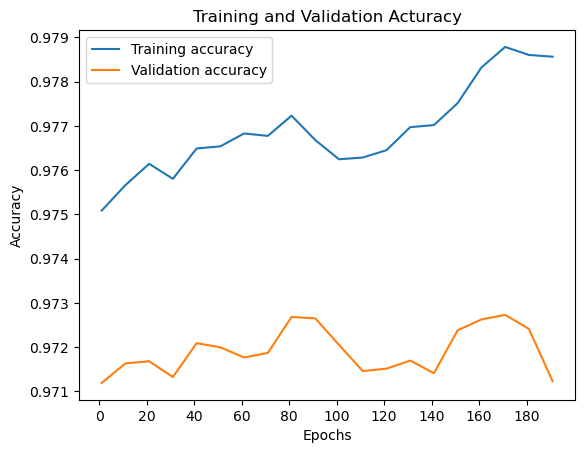

In [43]:
from matplotlib.pylab import plt
from numpy import arange

def moving_average(data, window_size):
    if len(data) < window_size:
        raise ValueError("Window size cannot be larger than the data size.")
    
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

print('train_loss_l:', len(train_acc_l))
print('test_loss_l:', len(test_acc_l))
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 200,10)
print('epochs:', len(epochs))

train_sl = moving_average(train_acc_l, 10)
test_sl = moving_average(test_acc_l, 10)

# Plot and label the training and validation loss values
plt.plot(epochs, train_sl[:20], label='Training accuracy')
plt.plot(epochs, test_sl[:20], label='Validation accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Acturacy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(arange(0, 200, 20))

# Display the plot
plt.legend(loc='best')
plt.show()